In [1]:
!!pip install torch transformers tensorly matplotlib GPUtil numpy

['Requirement already satisfied: torch in /usr/local/lib/python3.10/dist-packages (2.5.1+cu121)',
 'Requirement already satisfied: transformers in /usr/local/lib/python3.10/dist-packages (4.47.0)',
 'Collecting tensorly',
 '  Downloading tensorly-0.9.0-py3-none-any.whl.metadata (8.6 kB)',
 'Requirement already satisfied: matplotlib in /usr/local/lib/python3.10/dist-packages (3.7.5)',
 'Collecting GPUtil',
 '  Downloading GPUtil-1.4.0.tar.gz (5.5 kB)',
 '  Preparing metadata (setup.py): started',
 "  Preparing metadata (setup.py): finished with status 'done'",
 'Requirement already satisfied: numpy in /usr/local/lib/python3.10/dist-packages (1.26.4)',
 'Requirement already satisfied: filelock in /usr/local/lib/python3.10/dist-packages (from torch) (3.17.0)',
 'Requirement already satisfied: typing-extensions>=4.8.0 in /usr/local/lib/python3.10/dist-packages (from torch) (4.12.2)',
 'Requirement already satisfied: networkx in /usr/local/lib/python3.10/dist-packages (from torch) (3.4.2)',

In [2]:
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import GPUtil
import time
import numpy as np

In [3]:
from transformers import AutoTokenizer, AutoModelForCausalLM

# Load the tokenizer and model
model_name = "cerebras/Cerebras-GPT-111M"  # Choose the model size
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Move the model to GPU (if available)
model.to("cuda")

config.json:   0%|          | 0.00/359 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/486M [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(2048, 768)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-9): 10 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): GELUActivation()
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [4]:
!pip install datasets

In [5]:
from datasets import load_dataset
from transformers import AutoTokenizer

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("cerebras/Cerebras-GPT-6.7B")

# Set the padding token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token  # Use eos_token as pad_token

# Load a dataset (e.g., wikitext for language modeling)
dataset = load_dataset("wikitext", "wikitext-2-raw-v1")

# Tokenize the dataset
def tokenize_function(examples):
    tokenized = tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512, return_tensors="pt")
    tokenized["labels"] = tokenized["input_ids"]  # Add labels
    return tokenized

# Apply tokenization
tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Set format for PyTorch (include labels)
tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Verify the dataset
print(tokenized_dataset["train"][0].keys())

config.json:   0%|          | 0.00/361 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/733k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.36M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Map:   0%|          | 0/4358 [00:00<?, ? examples/s]

Map:   0%|          | 0/36718 [00:00<?, ? examples/s]

Map:   0%|          | 0/3760 [00:00<?, ? examples/s]

dict_keys(['input_ids', 'attention_mask', 'labels'])


In [6]:
from torch.utils.data import DataLoader

# Create dataloaders
train_dataloader = DataLoader(tokenized_dataset["train"], batch_size=8, shuffle=True)
val_dataloader = DataLoader(tokenized_dataset["validation"], batch_size=8)
test_dataloader = DataLoader(tokenized_dataset["test"], batch_size=8)

In [7]:
!pip install tdqm

  Preparing metadata (setup.py) ... done
  Created wheel for tdqm: filename=tdqm-0.0.1-py3-none-any.whl size=1320 sha256=1dc785eb1d11a456c5a83092d752fb068e378de7d60674b5b1af12e6f469cbba
  Stored in directory: /root/.cache/pip/wheels/37/31/b8/7b711038035720ba0df14376af06e5e76b9bd61759c861ad92
Successfully built tdqm


In [8]:
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import numpy as np
%matplotlib inline

class ResourceMonitor:
    def __init__(self):
        self.cpu_usage = []
        self.gpu_usage = []
        self.gpu_memory = []
        self.timestamps = []
        self.losses = []
        self.accuracies = []
        
    def update(self):
        self.timestamps.append(time.time())
        self.cpu_usage.append(psutil.cpu_percent())
        if torch.cuda.is_available():
            self.gpu_usage.append(torch.cuda.utilization())
            self.gpu_memory.append(torch.cuda.memory_allocated() / (1024 ** 2))  # MB
        else:
            self.gpu_usage.append(0)
            self.gpu_memory.append(0)
            
    def plot_resources(self):
        plt.figure(figsize=(12, 8))
        
        plt.subplot(2, 2, 1)
        plt.plot(self.timestamps, self.cpu_usage)
        plt.title('CPU Usage (%)')
        plt.xlabel('Time')
        plt.ylabel('Usage %')
        
        plt.subplot(2, 2, 2)
        plt.plot(self.timestamps, self.gpu_usage)
        plt.title('GPU Usage (%)')
        plt.xlabel('Time')
        plt.ylabel('Usage %')
        
        plt.subplot(2, 2, 3)
        plt.plot(self.timestamps, self.gpu_memory)
        plt.title('GPU Memory Usage (MB)')
        plt.xlabel('Time')
        plt.ylabel('Memory (MB)')
        
        plt.tight_layout()
        plt.show()

Epoch 1/2:   0%|          | 0/4590 [00:00<?, ?it/s]

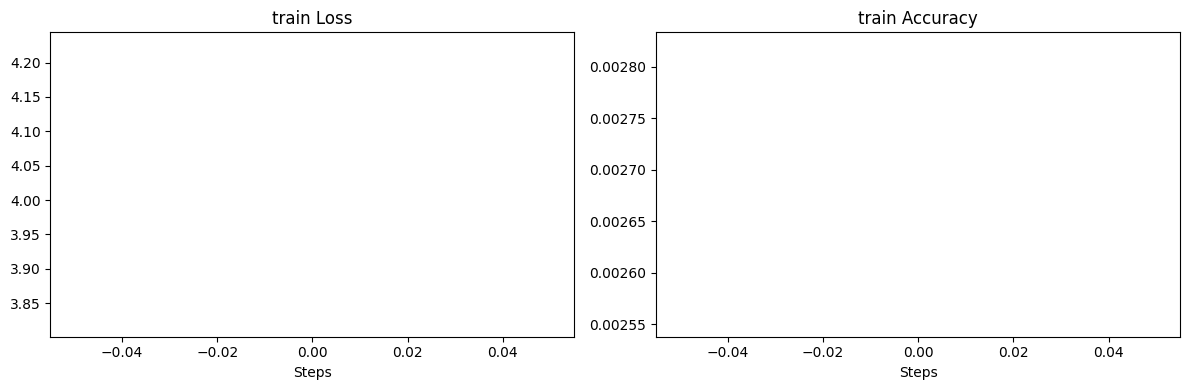

Epoch 1/2:  11%|█         | 500/4590 [03:58<32:30,  2.10it/s]

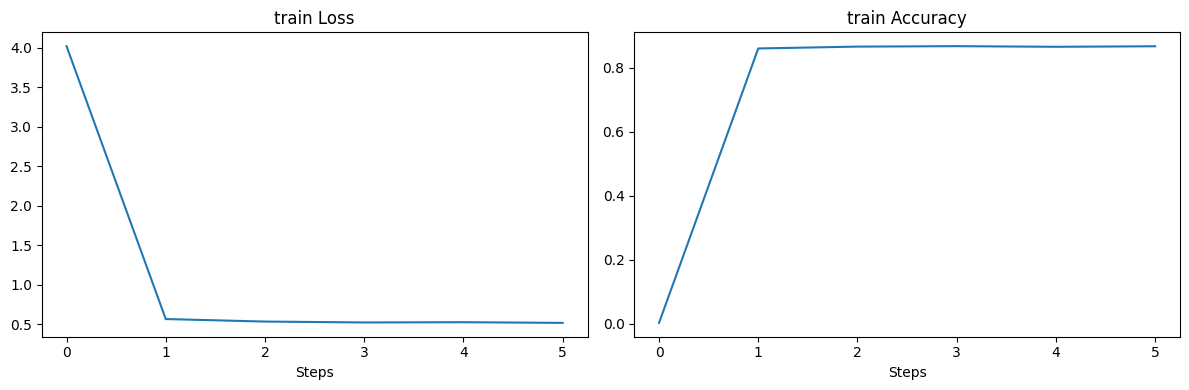

Epoch 1/2:  22%|██▏       | 1000/4590 [07:57<28:29,  2.10it/s]

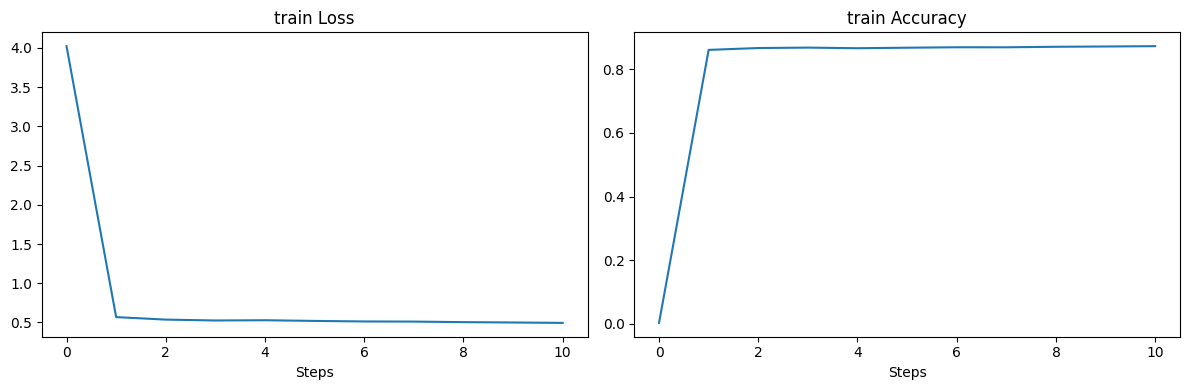

Epoch 1/2:  33%|███▎      | 1500/4590 [11:55<24:30,  2.10it/s]

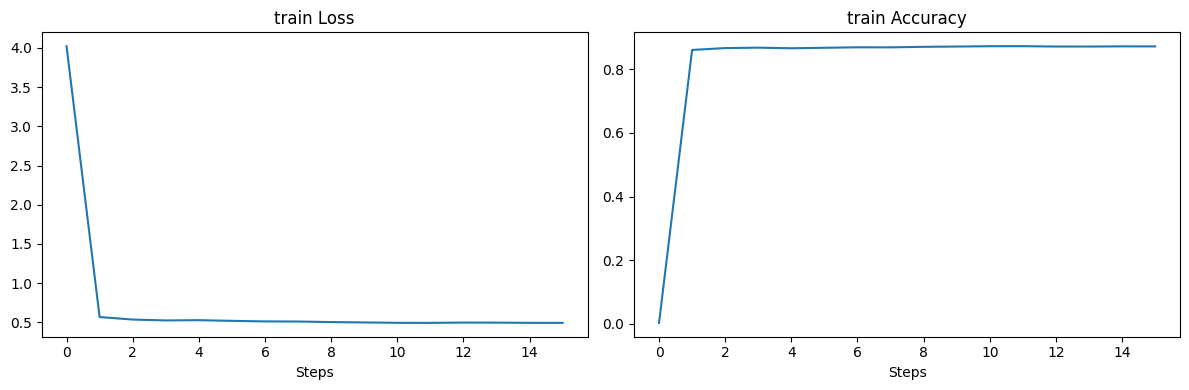

Epoch 1/2:  44%|████▎     | 2000/4590 [15:54<20:35,  2.10it/s]

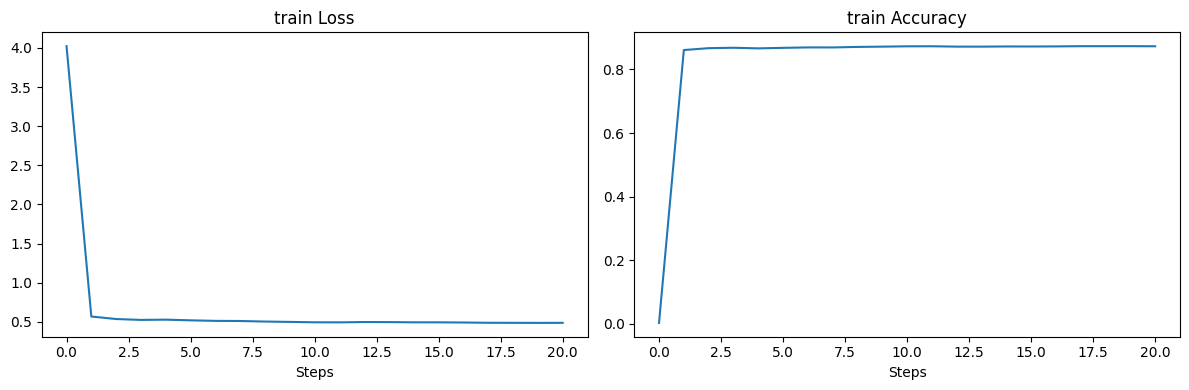

Epoch 1/2:  54%|█████▍    | 2500/4590 [19:53<16:38,  2.09it/s]

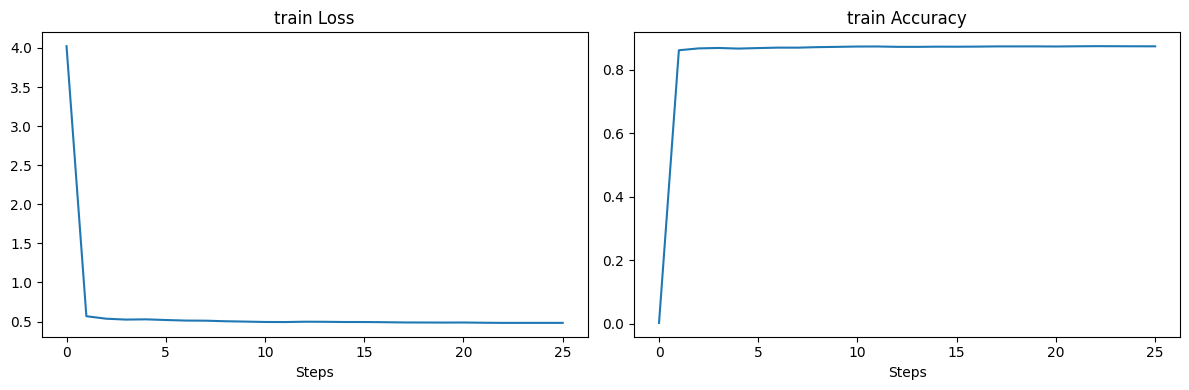

Epoch 1/2:  65%|██████▌   | 3000/4590 [23:52<12:38,  2.10it/s]

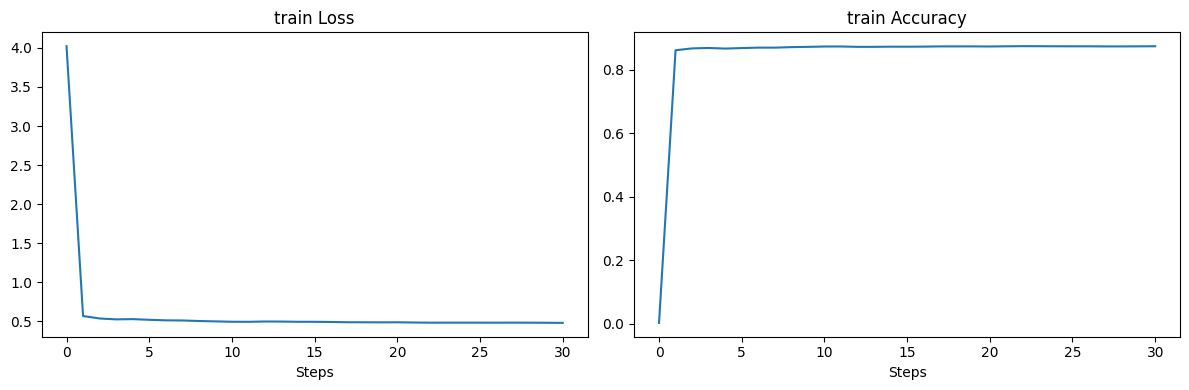

Epoch 1/2:  76%|███████▋  | 3500/4590 [27:51<08:39,  2.10it/s]

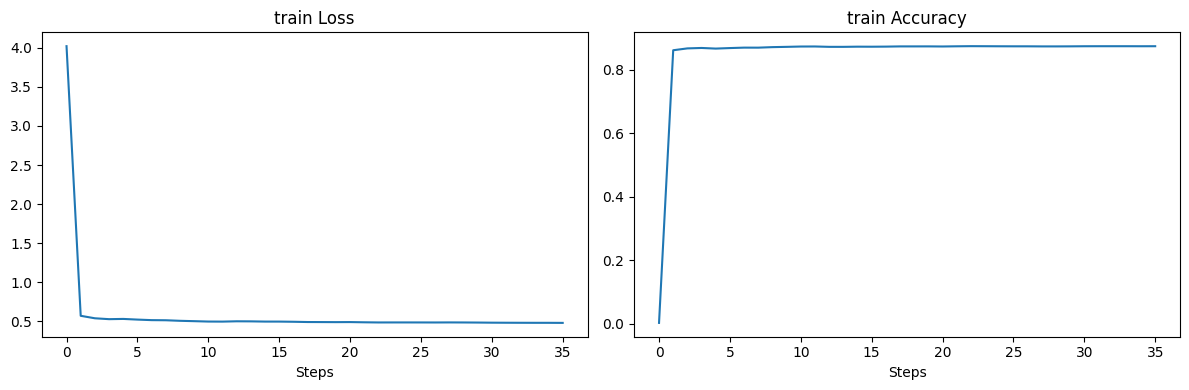

Epoch 1/2:  87%|████████▋ | 4000/4590 [31:50<04:41,  2.09it/s]

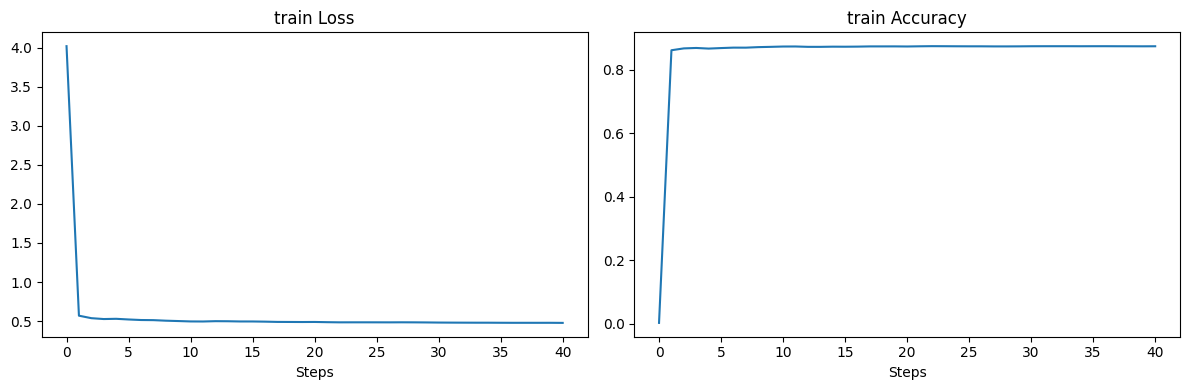

Epoch 1/2:  98%|█████████▊| 4500/4590 [35:48<00:43,  2.09it/s]

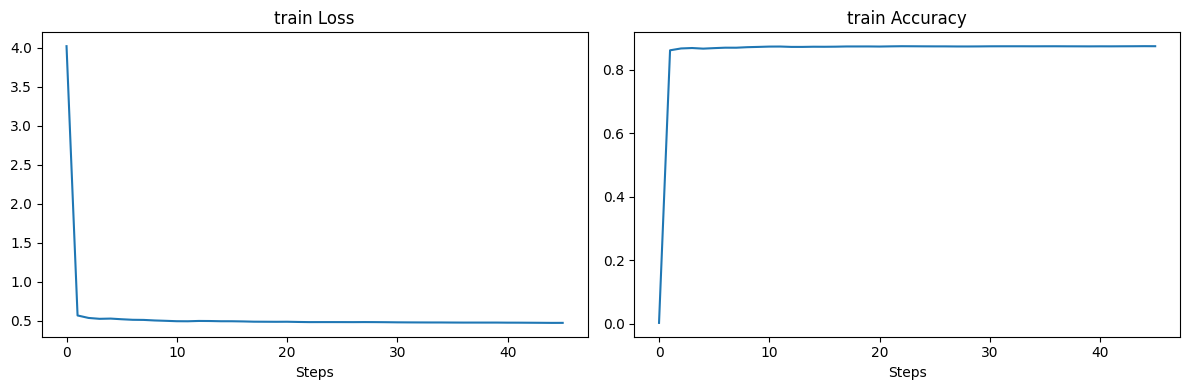

Epoch 1/2: 100%|██████████| 4590/4590 [36:32<00:00,  2.09it/s]


Epoch 1 - Loss: 0.4727, Accuracy: 0.8740


Epoch 2/2:   0%|          | 0/4590 [00:00<?, ?it/s]

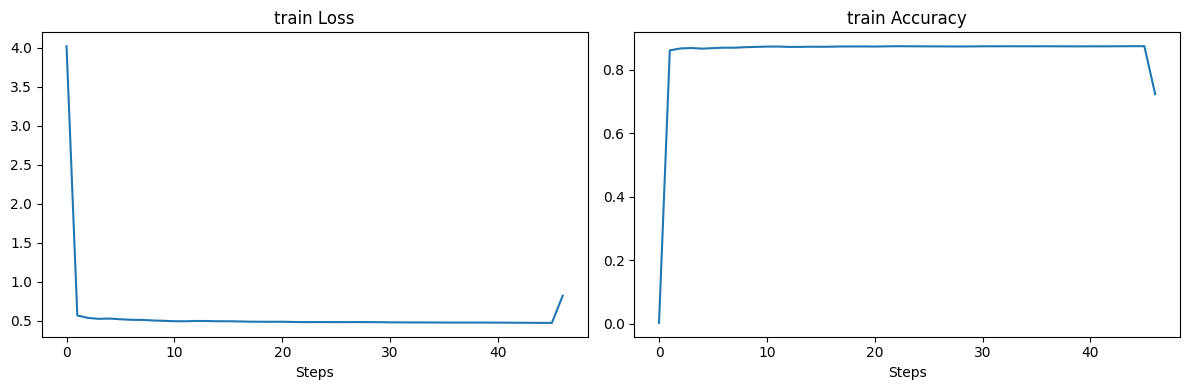

Epoch 2/2:  11%|█         | 500/4590 [03:59<32:26,  2.10it/s]

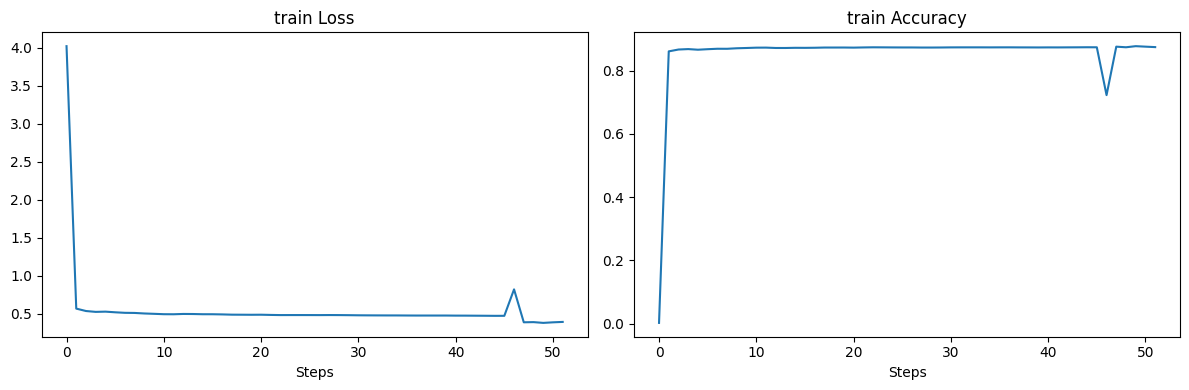

Epoch 2/2:  22%|██▏       | 1000/4590 [07:58<28:35,  2.09it/s]

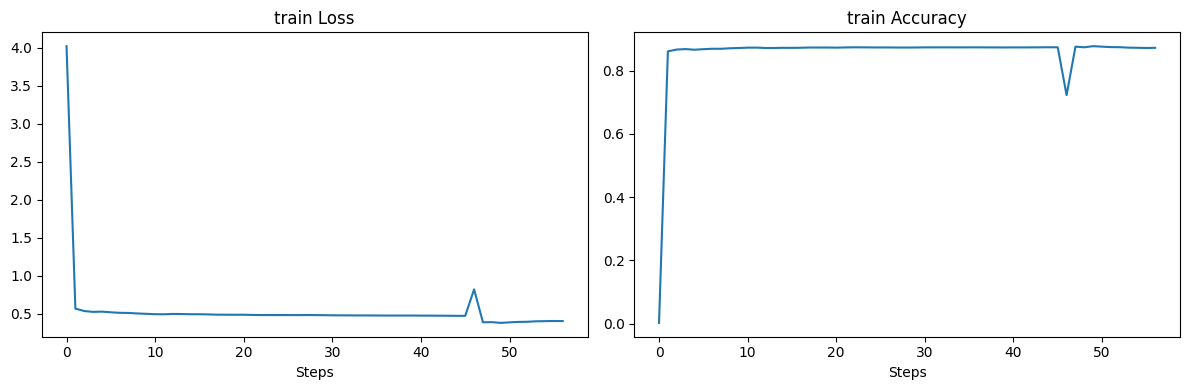

Epoch 2/2:  33%|███▎      | 1500/4590 [11:57<24:33,  2.10it/s]

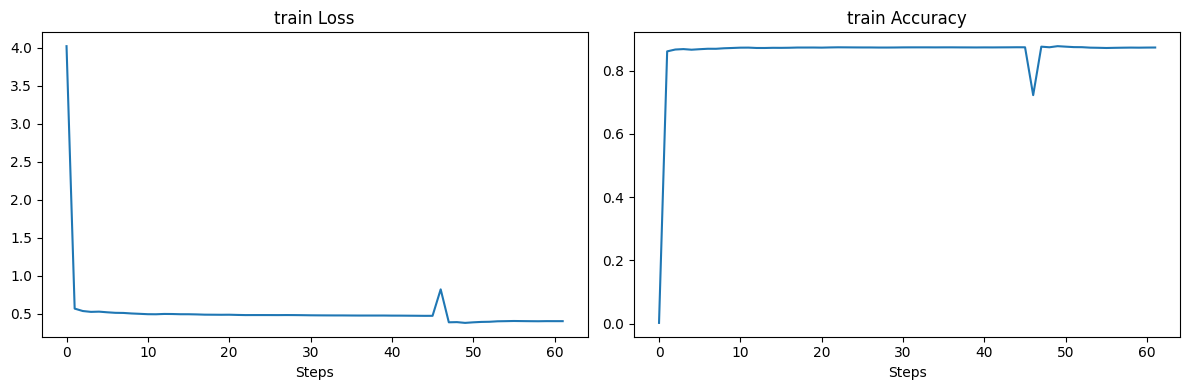

Epoch 2/2:  44%|████▎     | 2000/4590 [15:56<20:35,  2.10it/s]

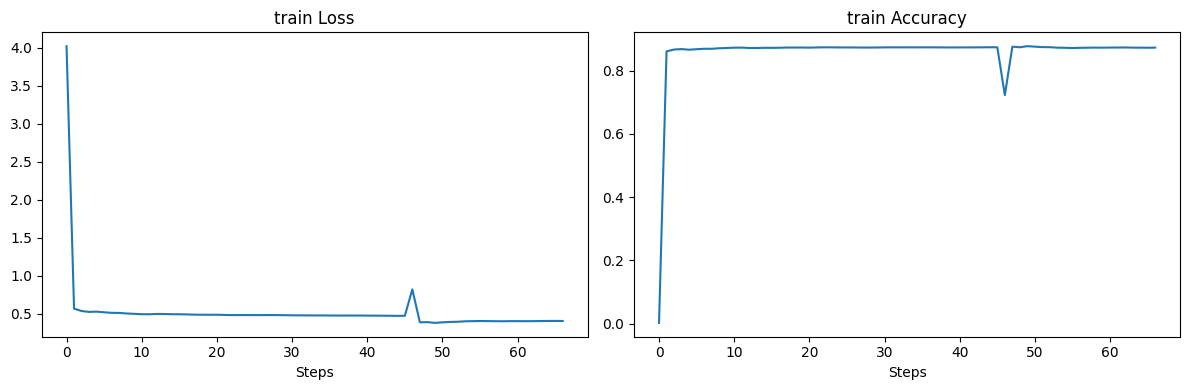

Epoch 2/2:  54%|█████▍    | 2500/4590 [19:55<16:35,  2.10it/s]

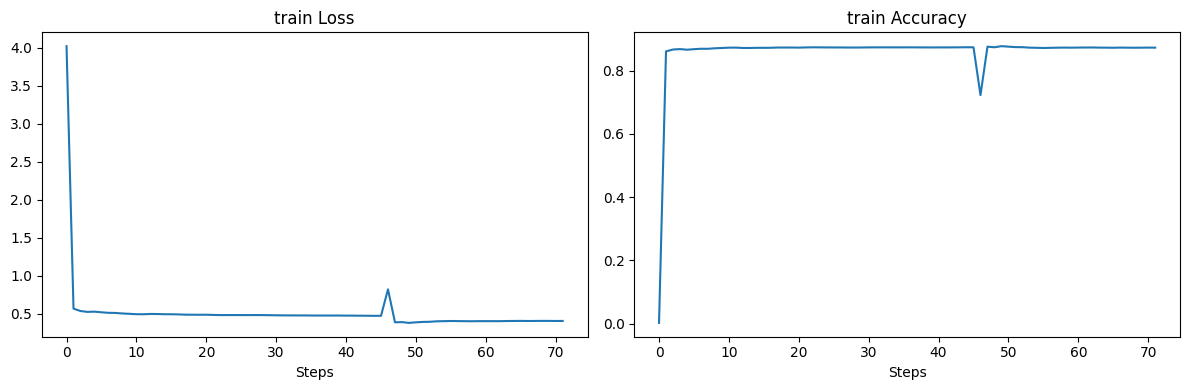

Epoch 2/2:  65%|██████▌   | 3000/4590 [23:54<12:38,  2.10it/s]

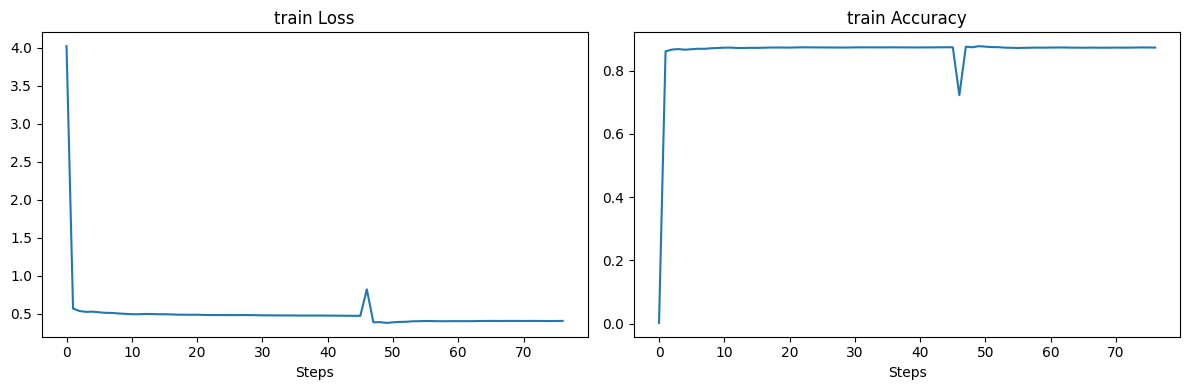

Epoch 2/2:  76%|███████▋  | 3500/4590 [27:52<08:39,  2.10it/s]

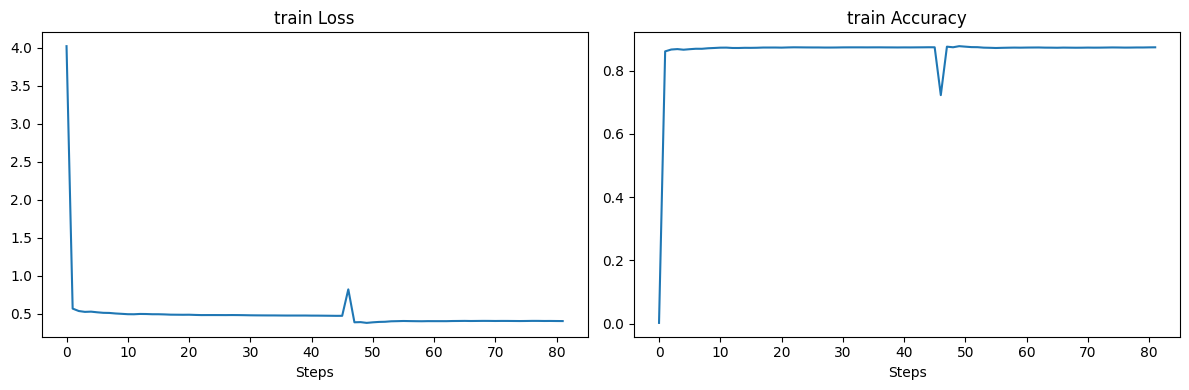

Epoch 2/2:  87%|████████▋ | 4000/4590 [31:52<04:42,  2.09it/s]

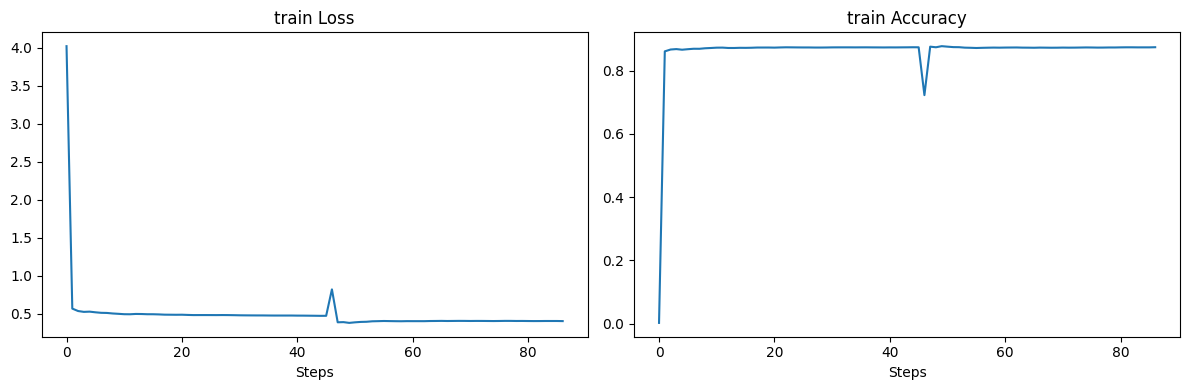

Epoch 2/2:  98%|█████████▊| 4500/4590 [35:51<00:42,  2.10it/s]

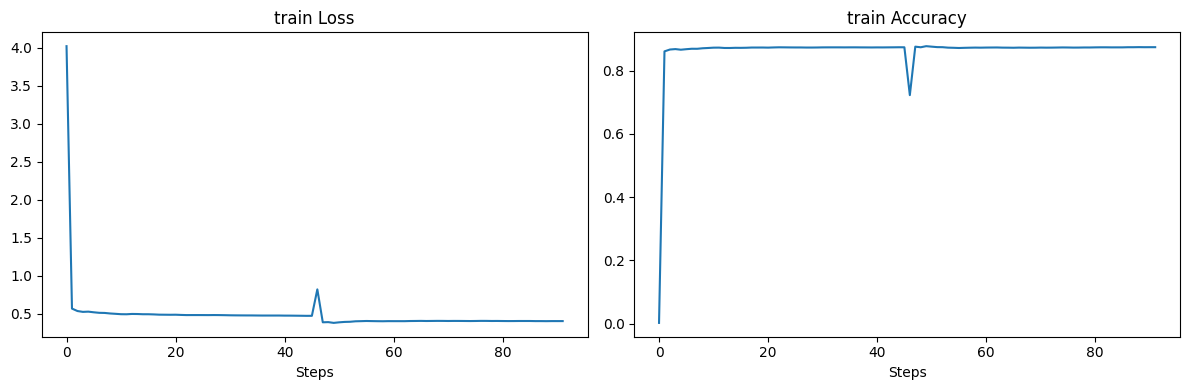

Epoch 2/2: 100%|██████████| 4590/4590 [36:34<00:00,  2.09it/s]


Epoch 2 - Loss: 0.4042, Accuracy: 0.8742


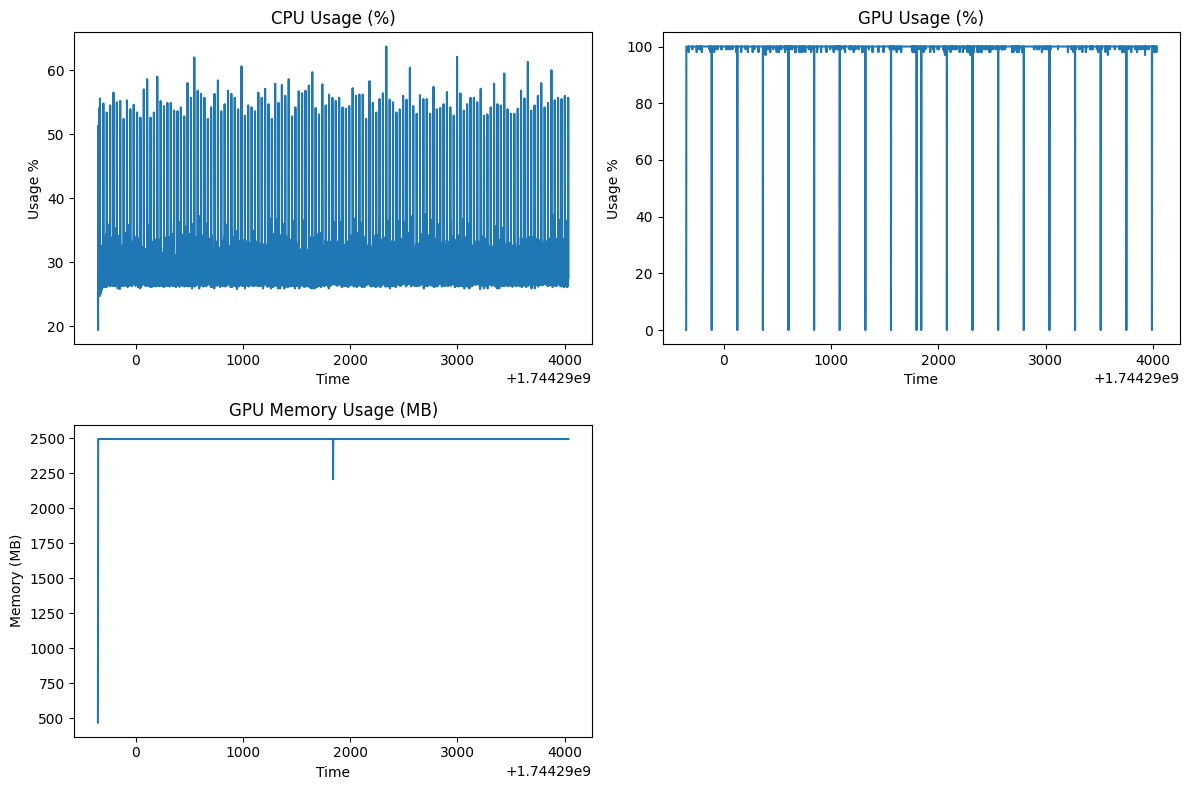

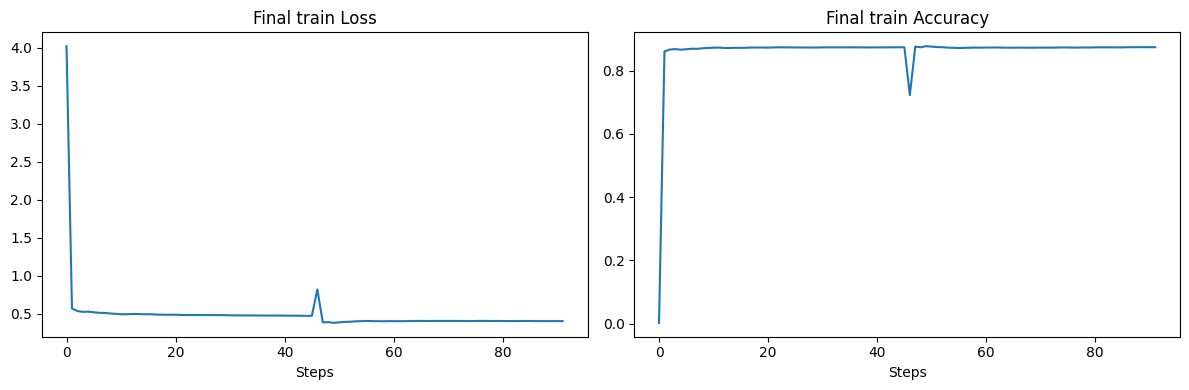

Training Time: 4386.79 seconds
CPU Usage: 4.199999999999999%
GPU Usage: 1738.99 MB
Training Loss: 0.4042
Training Accuracy: 0.8742


Validation: 100%|██████████| 470/470 [01:10<00:00,  6.69it/s]


Validate - Loss: 0.4968, Accuracy: 0.8728


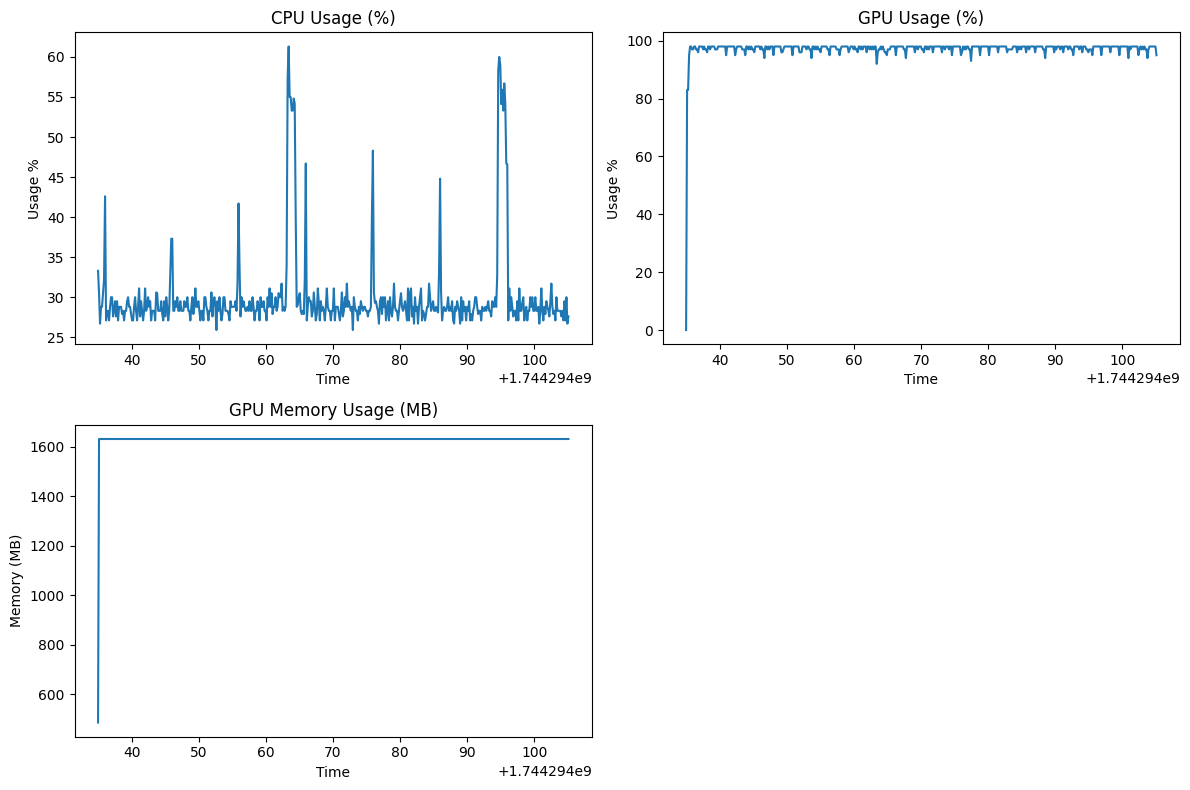

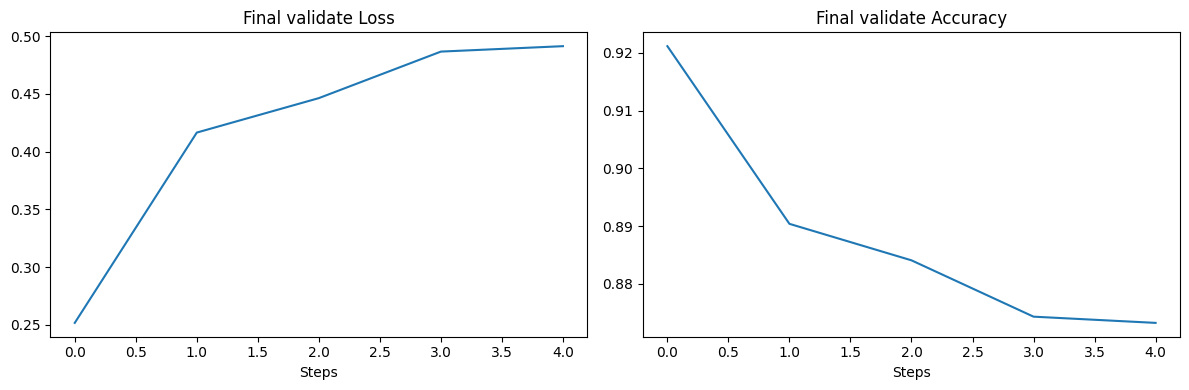

Validation Time: 70.25 seconds
CPU Usage: 4.5%
GPU Usage: 1146.06 MB
Validation Loss: 0.4968
Validation Accuracy: 0.8728


Testing: 100%|██████████| 545/545 [01:21<00:00,  6.70it/s]


Test - Loss: 0.4906, Accuracy: 0.8743


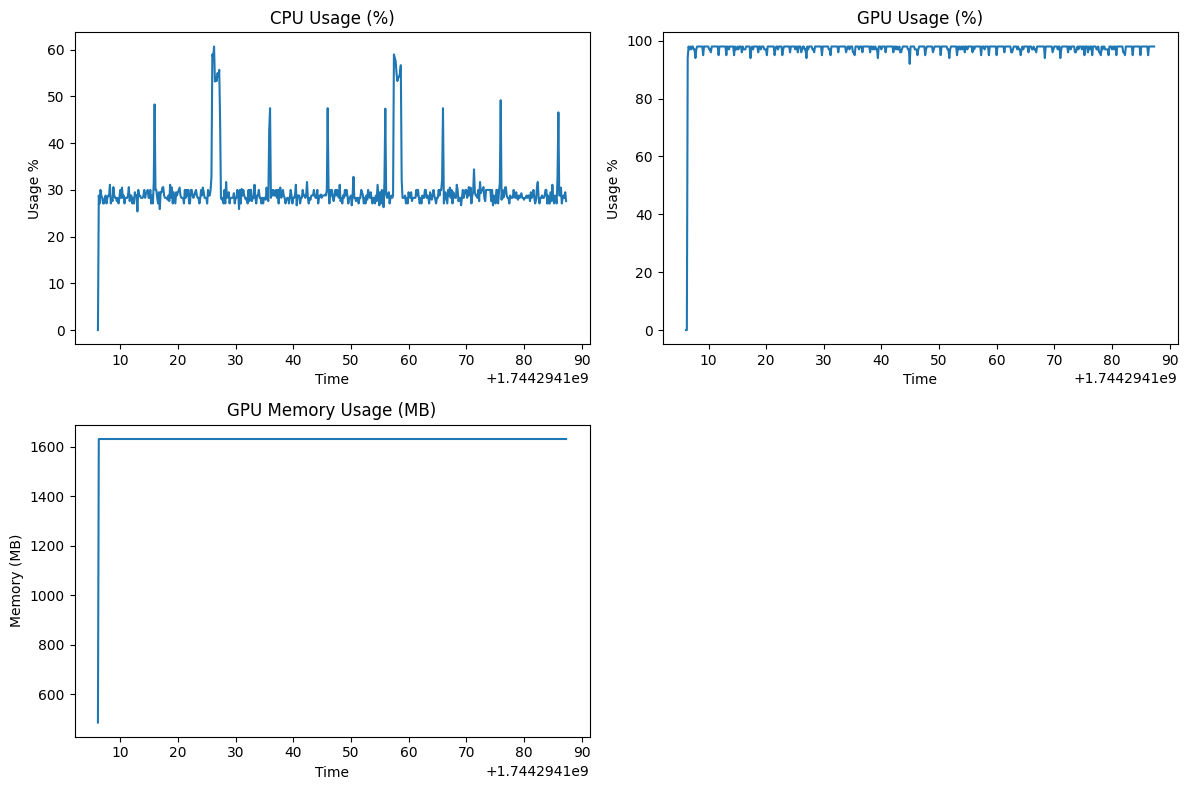

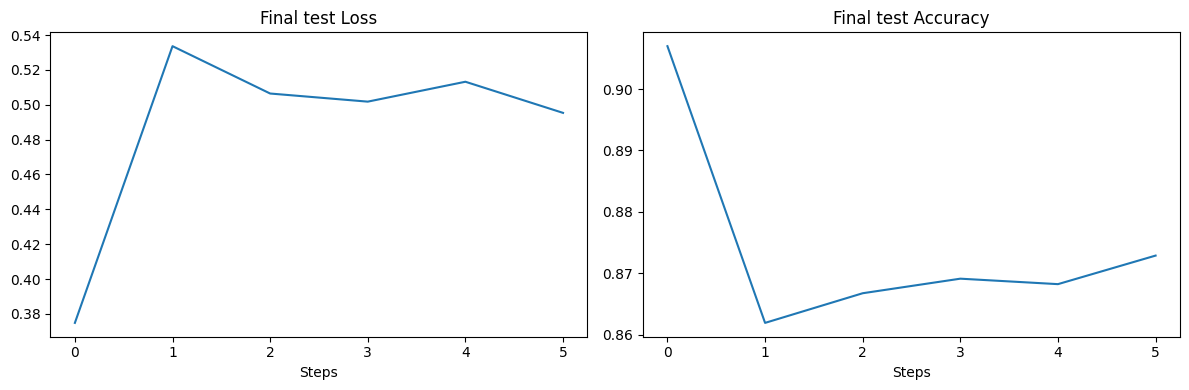

Testing Time: 81.31 seconds
CPU Usage: 1.3000000000000007%
GPU Usage: 859.00 MB
Testing Loss: 0.4906
Testing Accuracy: 0.8743


In [9]:
import time
import psutil
import torch
from tqdm import tqdm  # Import tqdm

# Define the device (GPU or CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"

# Function to measure energy and time
def measure_energy_and_time(model, dataloader, mode="train", epochs=1):
    writer = SummaryWriter()  # For tensorboard logging
    monitor = ResourceMonitor()
    
    start_time = time.time()
    cpu_start = psutil.cpu_percent(interval=None)
    gpu_start = torch.cuda.memory_allocated() if device == "cuda" else 0
    
    if mode == "train":
        optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
        model.train()
        
        for epoch in range(epochs):
            epoch_loss = 0
            correct = 0
            total = 0
            
            for batch_idx, batch in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")):
                # Update resource monitoring
                monitor.update()
                
                inputs = batch["input_ids"].to(device)
                labels = inputs
                
                # Forward pass
                outputs = model(inputs, labels=labels)
                loss = outputs.loss
                epoch_loss += loss.item()
                
                # Backward pass
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                
                # Calculate accuracy
                with torch.no_grad():
                    predictions = outputs.logits.argmax(dim=-1)
                    correct += (predictions == labels).sum().item()
                    total += labels.numel()
                
                # Log metrics every 100 steps
                if batch_idx % 100 == 0:
                    current_loss = epoch_loss / (batch_idx + 1)
                    current_acc = correct / total
                    monitor.losses.append(current_loss)
                    monitor.accuracies.append(current_acc)
                    
                    writer.add_scalar(f'{mode}/Loss', current_loss, epoch * len(dataloader) + batch_idx)
                    writer.add_scalar(f'{mode}/Accuracy', current_acc, epoch * len(dataloader) + batch_idx)
                    
                    # Plot intermediate results
                    if batch_idx % 500 == 0:
                        plt.figure(figsize=(12, 4))
                        plt.subplot(1, 2, 1)
                        plt.plot(monitor.losses)
                        plt.title(f'{mode} Loss')
                        plt.xlabel('Steps')
                        
                        plt.subplot(1, 2, 2)
                        plt.plot(monitor.accuracies)
                        plt.title(f'{mode} Accuracy')
                        plt.xlabel('Steps')
                        plt.tight_layout()
                        plt.show()
            
            avg_loss = epoch_loss / len(dataloader)
            avg_acc = correct / total
            print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.4f}")
    
    elif mode in ["validate", "test"]:
        model.eval()
        total_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for batch_idx, batch in enumerate(tqdm(dataloader, desc="Validation" if mode == "validate" else "Testing")):
                monitor.update()
                
                inputs = batch["input_ids"].to(device)
                labels = inputs
                outputs = model(inputs, labels=labels)
                loss = outputs.loss
                total_loss += loss.item()
                
                # Calculate accuracy
                predictions = outputs.logits.argmax(dim=-1)
                correct += (predictions == labels).sum().item()
                total += labels.numel()
                
                if batch_idx % 100 == 0:
                    current_loss = total_loss / (batch_idx + 1)
                    current_acc = correct / total
                    monitor.losses.append(current_loss)
                    monitor.accuracies.append(current_acc)
                    
                    writer.add_scalar(f'{mode}/Loss', current_loss, batch_idx)
                    writer.add_scalar(f'{mode}/Accuracy', current_acc, batch_idx)
        
        avg_loss = total_loss / len(dataloader)
        avg_acc = correct / total
        print(f"{mode.capitalize()} - Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.4f}")
    
    end_time = time.time()
    cpu_end = psutil.cpu_percent(interval=None)
    gpu_end = torch.cuda.memory_allocated() if device == "cuda" else 0

    # Calculate metrics
    elapsed_time = end_time - start_time
    cpu_usage = cpu_end - cpu_start
    gpu_usage = (gpu_end - gpu_start) / (1024 ** 2)  # Convert to MB
    
    # Plot final results
    monitor.plot_resources()
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(monitor.losses)
    plt.title(f'Final {mode} Loss')
    plt.xlabel('Steps')
    
    plt.subplot(1, 2, 2)
    plt.plot(monitor.accuracies)
    plt.title(f'Final {mode} Accuracy')
    plt.xlabel('Steps')
    plt.tight_layout()
    plt.show()
    
    return elapsed_time, cpu_usage, gpu_usage, avg_loss, avg_acc

# Benchmark training (now with visualization and more metrics)
train_time, train_cpu, train_gpu, train_loss, train_acc = measure_energy_and_time(
    model, train_dataloader, mode="train", epochs=2
)
print(f"Training Time: {train_time:.2f} seconds")
print(f"CPU Usage: {train_cpu}%")
print(f"GPU Usage: {train_gpu:.2f} MB")
print(f"Training Loss: {train_loss:.4f}")
print(f"Training Accuracy: {train_acc:.4f}")

# Benchmark validation
val_time, val_cpu, val_gpu, val_loss, val_acc = measure_energy_and_time(
    model, val_dataloader, mode="validate"
)
print(f"Validation Time: {val_time:.2f} seconds")
print(f"CPU Usage: {val_cpu}%")
print(f"GPU Usage: {val_gpu:.2f} MB")
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

# Benchmark testing
test_time, test_cpu, test_gpu, test_loss, test_acc = measure_energy_and_time(
    model, test_dataloader, mode="test"
)
print(f"Testing Time: {test_time:.2f} seconds")
print(f"CPU Usage: {test_cpu}%")
print(f"GPU Usage: {test_gpu:.2f} MB")
print(f"Testing Loss: {test_loss:.4f}")
print(f"Testing Accuracy: {test_acc:.4f}")

In [10]:
# Prepare a single batch for inference
batch = next(iter(test_dataloader))
inputs = batch["input_ids"].to(device)

# Measure inference
start_time = time.time()
cpu_start = psutil.cpu_percent(interval=None)
gpu_start = torch.cuda.memory_allocated() if device == "cuda" else 0

with torch.no_grad():
    outputs = model(inputs)

end_time = time.time()
cpu_end = psutil.cpu_percent(interval=None)
gpu_end = torch.cuda.memory_allocated() if device == "cuda" else 0

# Calculate metrics
inference_time = end_time - start_time
cpu_usage = cpu_end - cpu_start
gpu_usage = (gpu_end - gpu_start) / (1024 ** 2)  # Convert to MB

print(f"Inference Time: {inference_time:.2f} seconds, CPU Usage: {cpu_usage}%, GPU Usage: {gpu_usage:.2f} MB")

Inference Time: 0.01 seconds, CPU Usage: 24.4%, GPU Usage: 1146.00 MB


In [11]:
import pandas as pd

results = {
    "Training": {"Time": train_time, "CPU Usage": train_cpu, "GPU Usage": train_gpu},
    "Validation": {"Time": val_time, "CPU Usage": val_cpu, "GPU Usage": val_gpu},
    "Testing": {"Time": test_time, "CPU Usage": test_cpu, "GPU Usage": test_gpu},
    "Inference": {"Time": inference_time, "CPU Usage": cpu_usage, "GPU Usage": gpu_usage},
}

df = pd.DataFrame(results)
print(df)

              Training   Validation     Testing    Inference
Time       4386.791400    70.252759   81.312990     0.006554
CPU Usage     4.200000     4.500000    1.300000    24.400000
GPU Usage  1738.994629  1146.062988  858.996582  1146.000000


In [12]:
def calculate_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Calculating Accuracy", unit="batch"):
            inputs = batch["input_ids"].to(device)
            labels = inputs  # For next-token prediction, labels are the same as inputs
            outputs = model(inputs)
            predictions = outputs.logits.argmax(dim=-1)  # Get predicted token IDs
            correct += (predictions == labels).sum().item()
            total += labels.numel()

    accuracy = correct / total
    return accuracy

# Calculate accuracy for the test set
test_accuracy = calculate_accuracy(model, test_dataloader)
print(f"Test Accuracy: {test_accuracy:.4f}")

Calculating Accuracy: 100%|██████████| 545/545 [01:16<00:00,  7.17batch/s]

Test Accuracy: 0.8743


In [13]:
def calculate_loss(model, dataloader):
    model.eval()
    total_loss = 0
    total_samples = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Calculating Loss", unit="batch"):
            inputs = batch["input_ids"].to(device)
            outputs = model(inputs, labels=inputs)
            loss = outputs.loss
            total_loss += loss.item() * inputs.size(0)  # Multiply by batch size
            total_samples += inputs.size(0)

    avg_loss = total_loss / total_samples
    return avg_loss

# Calculate loss for the test set
test_loss = calculate_loss(model, test_dataloader)
print(f"Test Loss: {test_loss:.4f}")

Calculating Loss: 100%|██████████| 545/545 [01:20<00:00,  6.81batch/s]

Test Loss: 0.4905


In [14]:
# Access the first transformer block
transformer_block = model.transformer.h[0]

# Extract the combined query, key, and value weights
combined_weights = transformer_block.attn.c_attn.weight.data
print("Combined weights shape:", combined_weights.shape)

# Split the combined weights into query, key, and value weights
embed_dim = model.config.hidden_size
num_heads = model.config.num_attention_heads
head_dim = embed_dim // num_heads

query_weights = combined_weights[:embed_dim, :]
key_weights = combined_weights[embed_dim:2*embed_dim, :]
value_weights = combined_weights[2*embed_dim:, :]

print("Query weights shape:", query_weights.shape)
print("Key weights shape:", key_weights.shape)
print("Value weights shape:", value_weights.shape)

Combined weights shape: torch.Size([768, 2304])
Query weights shape: torch.Size([768, 2304])
Key weights shape: torch.Size([0, 2304])
Value weights shape: torch.Size([0, 2304])


In [15]:
print("Query weights shape:", query_weights.shape)

Query weights shape: torch.Size([768, 2304])


In [16]:
# Reshape the query weights for decomposition
tensor = query_weights.reshape(128, 128, 108)  # Reshape to 3D
print("Reshaped tensor shape:", tensor.shape)

Reshaped tensor shape: torch.Size([128, 128, 108])


In [17]:
import tensorly as tl
from tensorly.decomposition import parafac

# Set the backend to PyTorch
tl.set_backend("pytorch")

# Perform CP decomposition
rank = 5  # Choose the rank for decomposition
factors = parafac(tensor, rank=rank)

# Reconstruct the tensor from factors
reconstructed_tensor = tl.cp_to_tensor(factors)

print("Original tensor shape:", tensor.shape)
print("Reconstructed tensor shape:", reconstructed_tensor.shape)

Original tensor shape: torch.Size([128, 128, 108])
Reconstructed tensor shape: torch.Size([128, 128, 108])


In [18]:
# Reshape the reconstructed tensor back to the original shape
reconstructed_query_weights = reconstructed_tensor.reshape(query_weights.shape)
print("Reconstructed query weights shape:", reconstructed_query_weights.shape)

Reconstructed query weights shape: torch.Size([768, 2304])


In [19]:
# Replace the query weights in the model
combined_weights[:768, :] = reconstructed_query_weights

In [20]:
!pip install tensorboard

In [26]:
import torch

# Clear GPU memory
torch.cuda.empty_cache()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Starting fine-tuning with monitoring...


Step,Training Loss
100,0.314300
200,0.357500
300,0.339300
400,0.366500
500,0.331600
600,0.346400
700,0.343300
800,0.314800
900,0.359400
1000,0.349800


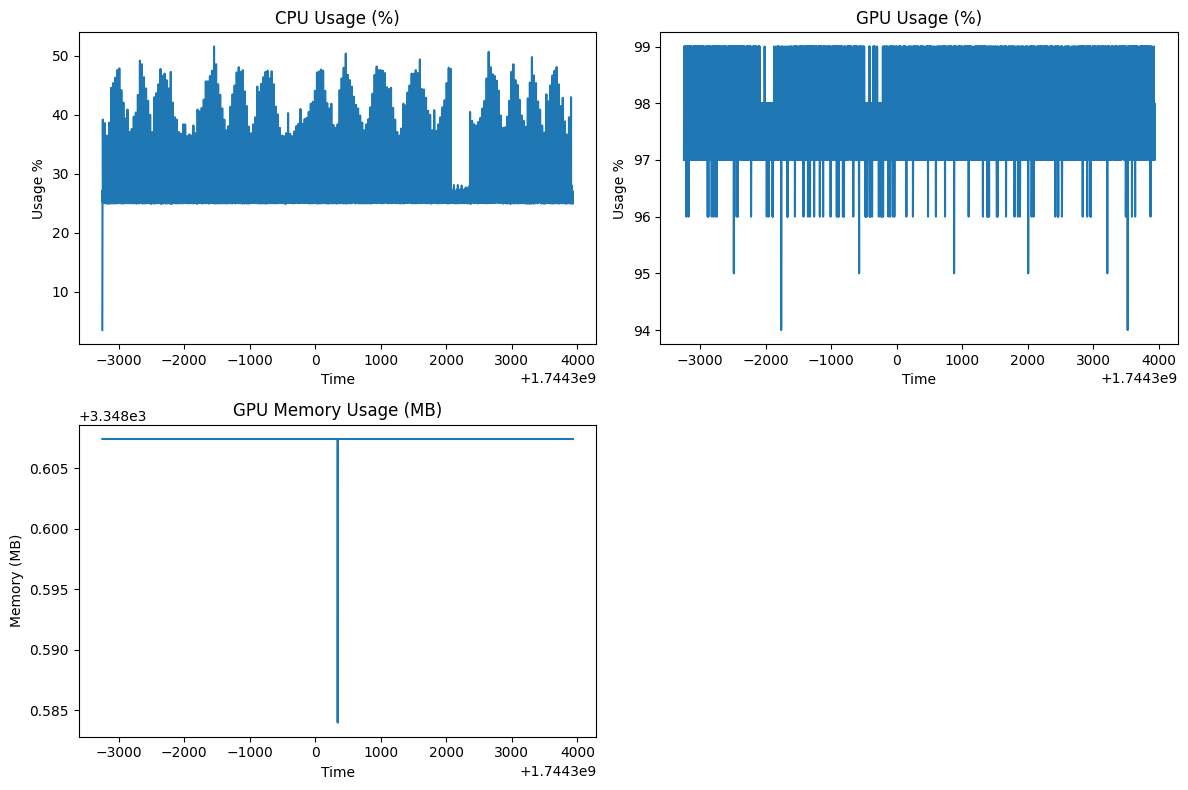

Fine-tuning completed with monitoring!


In [36]:
import time
import psutil
import torch
from transformers import Trainer, TrainingArguments

# Modify your fine-tuning section to use the monitoring
def fine_tune_with_monitoring():
    # Initialize monitoring
    monitor = ResourceMonitor()
    writer = SummaryWriter()
    
    # Your existing training_args setup
    training_args = TrainingArguments(
        output_dir="./results",
        num_train_epochs=2,
        per_device_train_batch_size=1,
        save_steps=10_000,
        logging_dir="./logs",
        logging_steps=100,
        report_to="tensorboard",
        fp16=True,
        gradient_accumulation_steps=16,
        disable_tqdm=False,
        evaluation_strategy="no",
    )
    
    # Custom callback for monitoring
    from transformers import TrainerCallback
    class MonitoringCallback(TrainerCallback):
        def on_step_end(self, args, state, control, **kwargs):
            monitor.update()
            
            # Log to tensorboard
            if state.global_step % 100 == 0:
                gpu_usage = torch.cuda.utilization() if torch.cuda.is_available() else 0
                gpu_mem = torch.cuda.memory_allocated() / (1024 ** 2)
                writer.add_scalar('Resources/CPU', psutil.cpu_percent(), state.global_step)
                writer.add_scalar('Resources/GPU', gpu_usage, state.global_step)
                writer.add_scalar('Resources/GPU_Memory', gpu_mem, state.global_step)
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset["train"],
        callbacks=[MonitoringCallback()]  # Add our monitoring callback
    )
    
    print("Starting fine-tuning with monitoring...")
    trainer.train()
    
    # Generate final plots
    monitor.plot_resources()
    print("Fine-tuning completed with monitoring!")

if __name__ == "__main__":
    fine_tune_with_monitoring()
